In [203]:
import numpy as np 
from dms import circle_family
from betti import *
from persistence import * 
from scipy.spatial.distance import pdist 
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [204]:
# %% circle data set 
C, params = circle_family(n=16, sd=0.15)
T = np.linspace(0, 3.0, 1000)
diagrams = [ripser(C(t))['dgms'][1] for t in T]
# birth, death = diagrams[int(len(diagrams))-1][0]*np.array([1.10, 0.90])
birth, death = diagrams[int(len(diagrams)/2)][0]*np.array([1.10, 0.90])
print(f"Birth: {birth}, Death: {death}")

Birth: 1.5127658009529115, Death: 2.23443717956543


In [205]:
print(np.vstack(diagrams))

[[0.00275048 0.00496542]
 [0.00550097 0.00993083]
 [0.00825145 0.01489625]
 ...
 [2.74223185 4.95051956]
 [2.74498224 4.95548487]
 [2.74773264 4.96045017]]


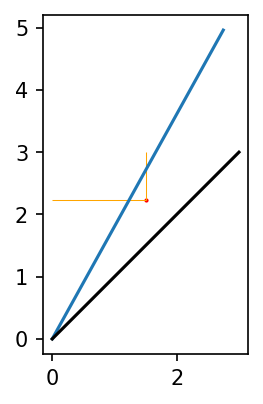

In [206]:
DGM = np.vstack(diagrams)
fig = plt.figure(figsize=(3,3), dpi=150)
ax = plt.gca()
ax.plot(*np.vstack(diagrams).T)
ax.plot(np.linspace(0, 3, 100), np.linspace(0, 3, 100), c='black')
ax.set_aspect('equal')
ax.scatter(birth, death,c='red',s=1.0)
ax.hlines(y=death, xmin=0, xmax=birth, colors='orange', lw=0.5)
ax.vlines(x=birth, ymin=death, ymax=3.0, colors='orange', lw=0.5)
feasible = np.flatnonzero(np.logical_and(DGM[:,0] <= birth, DGM[:,1] > death))


In [207]:
#plt.plot(T, int(feasible))
print(f"Feasible range in T: {np.min(T[feasible]), np.max(T[feasible])}")

Feasible range in T: (1.3513513513513513, 1.6486486486486487)


In [208]:
### NORMALIZING CONSTANTS DONT FORGET
nuclear_norm = lambda A: np.sum(np.linalg.svd(A, compute_uv=False))
spectral_norm = lambda A: np.max(np.linalg.svd(A, compute_uv=False))

def g(D: ArrayLike): # unnormalized
  D1, (vw, ew) = rips_boundary(D, p=1, diam=np.inf, sorted=False) 
  D2, (ew, tw) = rips_boundary(D, p=2, diam=np.inf, sorted=False)
  D1.data = np.sign(D1.data)*np.maximum(birth - np.repeat(ew, 2), 0.0)
  D2.data = np.sign(D2.data)*np.maximum(death - np.repeat(tw, 3), 0.0) 
  return(D1, D2)

def h(D: ArrayLike): # unnormalized
  D3, (ew, tw) = rips_boundary(D, p=2, diam=np.inf, sorted=False)
  D0 = csc_matrix(np.diag(np.maximum(birth - ew, 0.0)))
  D3 = D3.tocoo()
  #D3.data = np.sign(D3.data)*np.minimum(np.maximum(death - tw[D3.col], 0.0), np.maximum(ew[D3.row] - birth, 0.0))
  D3.data = np.sign(D3.data)*np.maximum(ew[D3.row] - birth, 0.0)
  return(D0, D3.tocsc())

m1 = np.max([spectral_norm(g(pdist(C(t)))[0].A) for t in T])
m2 = np.max([spectral_norm(g(pdist(C(t)))[1].A) for t in T])
m0 = np.max([np.max(birth - pdist(C(t))) for t in T])
m3 = np.max([spectral_norm(h(pdist(C(t)))[1].A) for t in T])

## Normalize using constants 
g_norm = lambda t: tuple(np.array([1/m1, 1/m2])*g(pdist(C(t))))
h_norm = lambda t: tuple(np.array([1/m0, 1/m3])*h(pdist(C(t))))

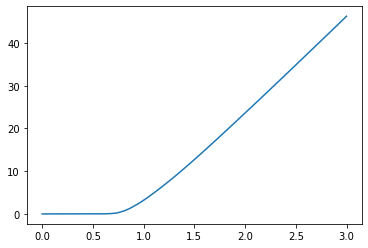

In [209]:
## This is indeed convex with the single rule
## non-convex with the double rule
plt.plot(T, np.array([nuclear_norm(((1/m3)*h(pdist(C(t)))[1]).A) for t in T]))

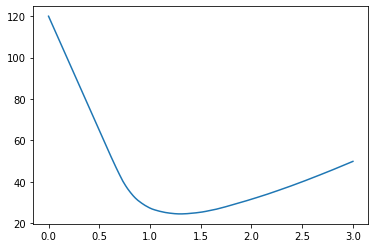

In [210]:
## This is convex
t2 = np.array([np.sum([nuclear_norm(A.A) for A in h_norm(t)]) for t in T])
plt.plot(T, t2)

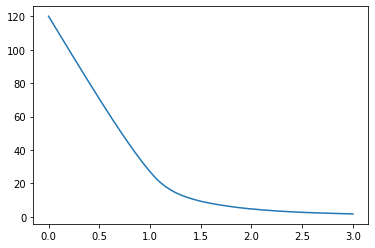

In [211]:
## This is convex
t1 = np.array([np.sum([nuclear_norm(A.A) for A in g_norm(t)]) for t in T])
plt.plot(T, t1)

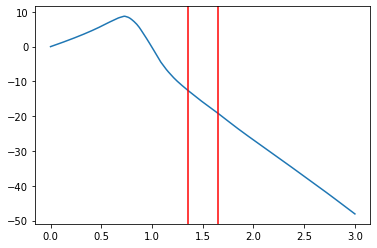

In [212]:
## This is not convex, but should be a DC
plt.plot(T, t1-t2)
plt.axvline(x=T[np.min(feasible)], color='r')
plt.axvline(x=T[np.max(feasible)], color='r')

In [213]:
## Show ranks
h0_r = np.array([np.linalg.matrix_rank(h_norm(t)[0].A) for t in T])
h0_n = np.array([nuclear_norm(h_norm(t)[0].A) for t in T])
h1_r = np.array([np.linalg.matrix_rank(h_norm(t)[1].A) for t in T])
h1_n = np.array([nuclear_norm(h_norm(t)[1].A) for t in T])

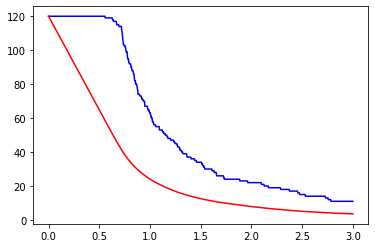

In [214]:
plt.plot(T, h0_r, c='blue')
plt.plot(T, h0_n, c='red')

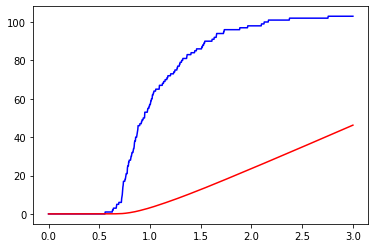

In [215]:
plt.plot(T, h1_r, c='blue')
plt.plot(T, h1_n, c='red')

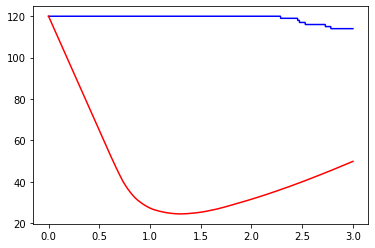

In [216]:
plt.plot(T, h0_r+h1_r, c='blue')
plt.plot(T, h0_n+h1_n, c='red')

In [217]:
# ?? 
np.unique(h0_r+h1_r)

array([114, 115, 116, 117, 118, 119, 120])

In [218]:
g0_r = np.array([np.linalg.matrix_rank(g_norm(t)[0].A) for t in T])
g0_n = np.array([nuclear_norm(g_norm(t)[0].A) for t in T])
g1_r = np.array([np.linalg.matrix_rank(g_norm(t)[1].A) for t in T])
g1_n = np.array([nuclear_norm(g_norm(t)[1].A) for t in T])

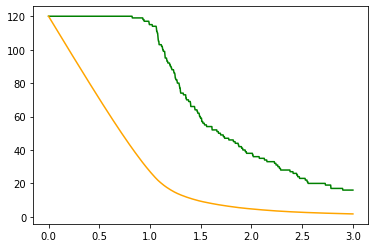

In [219]:
plt.plot(T, g0_r+g1_r, c='green')
plt.plot(T, g0_n+g1_n, c='orange')

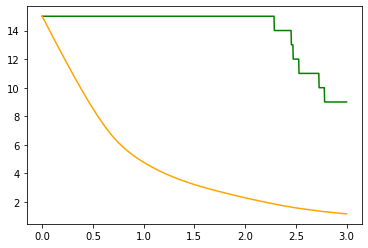

In [220]:
plt.plot(T, g0_r, c='green')
plt.plot(T, g0_n, c='orange')

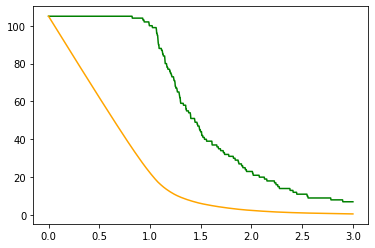

In [221]:
plt.plot(T, g1_r, c='green')
plt.plot(T, g1_n, c='orange')

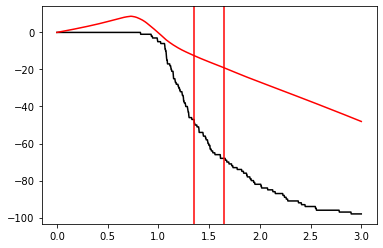

In [222]:
plt.plot(T, (g0_r+g1_r)-(h0_r+h1_r), c='black')
plt.plot(T, (g0_n+g1_n)-(h0_n+h1_n), c='red')
plt.axvline(x=T[np.min(feasible)], color='r')
plt.axvline(x=T[np.max(feasible)], color='r')

[[  15  105 -120    0]
 [  15  105 -120    0]
 [  15  105 -120    0]
 ...
 [   9    7  -11 -103]
 [   9    7  -11 -103]
 [   9    7  -11 -103]]


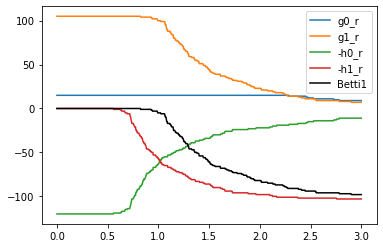

In [223]:
R = np.c_[g0_r, g1_r, -h0_r, -h1_r]
print(R)
plt.plot(T, g0_r, label='g0_r')
plt.plot(T, g1_r, label='g1_r')
plt.plot(T, -h0_r, label='-h0_r')
plt.plot(T, -h1_r, label='-h1_r')
plt.plot(T, R.sum(axis=1), label='Betti1', c='black')
plt.legend()